# Ensemble

## Import Package


In [1]:
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import xgboost as xgb

In [3]:
from utils.metrics import evaluate

## Const & Inputs

Here are all of the parameters to change for the run.


In [4]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# Number of classes in the dataset
num_classes = 33

# options: (subset, fullset)
train_mode = 'fullset'

# Models for ensemble
models = [
    {
        'name': 'bit',
        'path': 'BiT-M-R50x1_batch256_lr0.0003_fullset_v2'
    }, 
    {
        'name': 'efficientnet',
        'path': 'fullset_224_crop70xy_correct_by_rule_efficientnetb3_transfer_trainable_epochs100_batchsize64_lr0.0005_reducelr_dropout40'
    }, 
    {
        'name': 'dcnn',
        'path': 'DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-classWeight-hmConcat-270rotate-85'
    }, 
]


## Data Preprocessing

### Load Data

Load the prediction results of 3 models and merge into a DataFrame.

In [5]:
data = pd.read_pickle(F'{path}/data/{train_mode}.pkl').sort_values(by=['file']).reset_index(drop=True)

In [6]:
# Copy result from each model
for i in range(len(models)):
    print(models[i]['name'])
    result = pd.read_pickle(F'{path}/outputs/train/{models[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    data[f'predict_{models[i]["name"]}'] = result['predict']
    data[f'predict_label_{models[i]["name"]}'] = result['predict_label']

bit
efficientnet
dcnn


### Encode categorical features

OneHotEncoder or LabelEncoder.


In [7]:
from sklearn.preprocessing import LabelEncoder
# Class for label
labelenc = LabelEncoder()
labelenc.fit(data['label'].values)
data['class'] = labelenc.transform(data['label'].values)

### Split Data & Evaluate

Split data into train, validation and test sets.


In [8]:
train = data[data['set_name'].eq('train') | data['set_name'].eq('test')].reset_index(drop=True)
valid = data[data['set_name'].eq('valid')].reset_index(drop=True)
# Generate test from valid(8:2)
valid['test_in_valid'] = np.nan
valid.groupby(['label', 'county_name']).apply(lambda x: valid["test_in_valid"].fillna(pd.Series(data=1, index=x.sample(frac=0.20, random_state=5397).index), inplace=True))
test = valid[valid['test_in_valid'].eq(1)].reset_index(drop=True)
valid = valid[~valid['test_in_valid'].eq(1)].reset_index(drop=True)
print(F"data: {data.shape}, train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

data: (89514, 28), train: (76124, 28), valid: (10727, 29), test: (2663, 29)


In [9]:
# Evaluate each model on train
print('train')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(train['label'].tolist(), train[f'predict_label_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

train
bit 0.9483
efficientnet 0.9265
dcnn 0.9978


In [10]:
# Evaluate each model on valid
print('valid')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(valid['label'].tolist(), valid[f'predict_label_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

valid
bit 0.8751
efficientnet 0.7603
dcnn 0.7521


## Classification Prediction
Based on the output of each model.

In [11]:
def initialize_model(params, num_classes):
    # Initialize these variables which will be set in this if statement, each of these variables is model specific.
    model_ft = None
    model_ft = xgb.XGBClassifier(**params)
    return model_ft

In [12]:
valid.columns[8:]

Index(['target_fid', 'target_x', 'target_y', 'county_name', 'town_name',
       'town_x', 'town_y', 'town_z', 'set_name', 'angle', 'shape', 'width',
       'height', 'predict_bit', 'predict_label_bit', 'predict_efficientnet',
       'predict_label_efficientnet', 'predict_dcnn', 'predict_label_dcnn',
       'class', 'test_in_valid'],
      dtype='object')

In [13]:
def build_x_y(df, models, list_of_use_models):
    # Build inputs of prob from each model
    x = np.concatenate([
        np.array(df[f'predict_{models[i]["name"]}'].tolist()) for i in list_of_use_models
    ], axis=1)
    # Add doy & camera
    x = np.concatenate([
        x,
        # df['town_x'].values.reshape(-1, 1),
        # df['town_y'].values.reshape(-1, 1),
        # df['town_z'].values.reshape(-1, 1),
    ], axis=1)
    y = np.array(df['class'].tolist())
    return x, y

In [17]:
list_of_use_models = [i for i in range(len(models))]

# Print the new model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

# Build x, y for model
x_valid, y_valid = build_x_y(valid, models, list_of_use_models)
x_test, y_test = build_x_y(test, models, list_of_use_models)

# best_params = read_pkl(f'./models/vit-eff6-dcnn(doy-sig)-dcnn(doy)-Hyperopt1000.pkl')
best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0, 'n_estimators': 500}

# Create model & train
clf = initialize_model(best_params, num_classes)
clf.fit(x_valid, y_valid)

bit-efficientnet-dcnn


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_class=33, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [18]:
# Predict the response for test dataset
y_pred = clf.predict(x_test)

# Save the best model
# clf.save_model(F"{path}/models/ensemble-xgb-{model_set}.json")

# Transform the encoded predictions to their actual values
y_test_inverse = labelenc.inverse_transform(y_test)
y_pred_inverse = labelenc.inverse_transform(y_pred)

# Evaluate the model
evaluation = evaluate(y_test_inverse.tolist(), y_pred_inverse.tolist())
print(round(pd.DataFrame(evaluation).T['precision']['weighted avg'], 6))    

0.889204


In [ ]:
# best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0, 'n_estimators': 500}
# 0.889204
# best_params + town_z
# 0.889119
# best_params + town_x + town_y + town_z
# 0.887062

#### Hyperparameter Optimization
2 & 5

In [14]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.iteration = 0
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo,
                          max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return {'result': result, 'history': trials}

    def xgb_clf(self, para):
        clf = xgb.XGBClassifier(**para['clf_params'])
        return self.train_clf(clf, para)

    def train_clf(self, clf, para):
        self.iteration += 1
        time_start = time.time()
        clf.fit(
            self.x_train, self.y_train,
            **para['fit_params']
        )
        pred = clf.predict(self.x_test)
        time_end = time.time()
        run_time = time_end - time_start

        loss = para['loss_func'](self.y_test, pred)
        return {'iteration': self.iteration, 'loss': loss, 'train_time': run_time, 'params': para, 'status': STATUS_OK}

In [15]:
from hyperopt.pyll.base import scope
# from hyperopt.pyll.stochastic import sample
# sample(scope.int(hp.quniform('example', 0, 10, 1)))
# Returns an integer from 0 to 10, inclusive

xgb_para = dict()
xgb_para['clf_params'] = {
    'objective':        'multi:softproba',   
    'num_class':        num_classes,
    'tree_method':      'gpu_hist', 
    'gpu_id':           0,
    'eval_metric':      'auc',
    'booster':          'gbtree',
    'n_estimators':     scope.int(hp.quniform('n_estimators', 200, 800, 100)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.0005), np.log(0.05)),
    'gamma':            hp.uniform ('gamma', 0.0, 4.0), # min_split_loss
    'max_depth':        scope.int(hp.quniform('max_depth', 1, 20, 2)),
    'min_child_weight': hp.quniform('min_child_weight', 10, 20, 1),
    'max_delta_step':   hp.quniform('max_delta_step', 0, 20, 2),
    'subsample':        hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
    'reg_alpha':        hp.uniform('reg_alpha', 0.4, 1.0),  # L1 regularization
    'reg_lambda':       hp.uniform('reg_lambda', 0.0, 1.0), # L2 regularization
}
xgb_para['fit_params'] = {}
xgb_para['loss_func'] = lambda y, pred: -evaluate(y.tolist(), pred.tolist())['weighted avg']['f1-score']

bit-efficientnet-dcnn
100%|██████████| 300/300 [2:21:52<00:00, 28.38s/trial, best loss: -0.8994564616035203]  


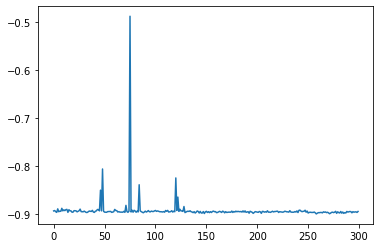

In [16]:

iteration = 300

# Obtain all models index
list_of_use_models = [i for i in range(len(models))]
    
# Print model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

# Build x, y for model
x_valid, y_valid = build_x_y(valid, models, list_of_use_models)
x_test, y_test = build_x_y(test, models, list_of_use_models)
    
# Init
obj = HPOpt(x_valid, x_test, y_valid, y_test)

# Run optimization
trials = Trials()
opt = obj.process(fn_name='xgb_clf', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=iteration)

# Show best params 
history = pd.DataFrame(opt['history'].results)
best_params = history.loc[history['loss'].idxmin()]['params']['clf_params']

# (cpu)opt x2 = 19:56
# (gpu)opt x2 = 07:29, 1 = 4:30
# (gpu)opt x10 = 50:10, 1 = 5:00

# Save best params
# save dict to json
with open(F'{path}/models/{model_set}-hyperopt{iteration}-2.json', 'w') as f:
    json.dump(best_params, f)
history.to_csv(F'{path}/models/{model_set}-hyperopt{iteration}-2.csv')

# Drow loss
plt.plot(history['loss'])
#   1%|          | 3/500 [02:23<7:15:10, 52.54s/trial, best loss: -0.8926996607624745]


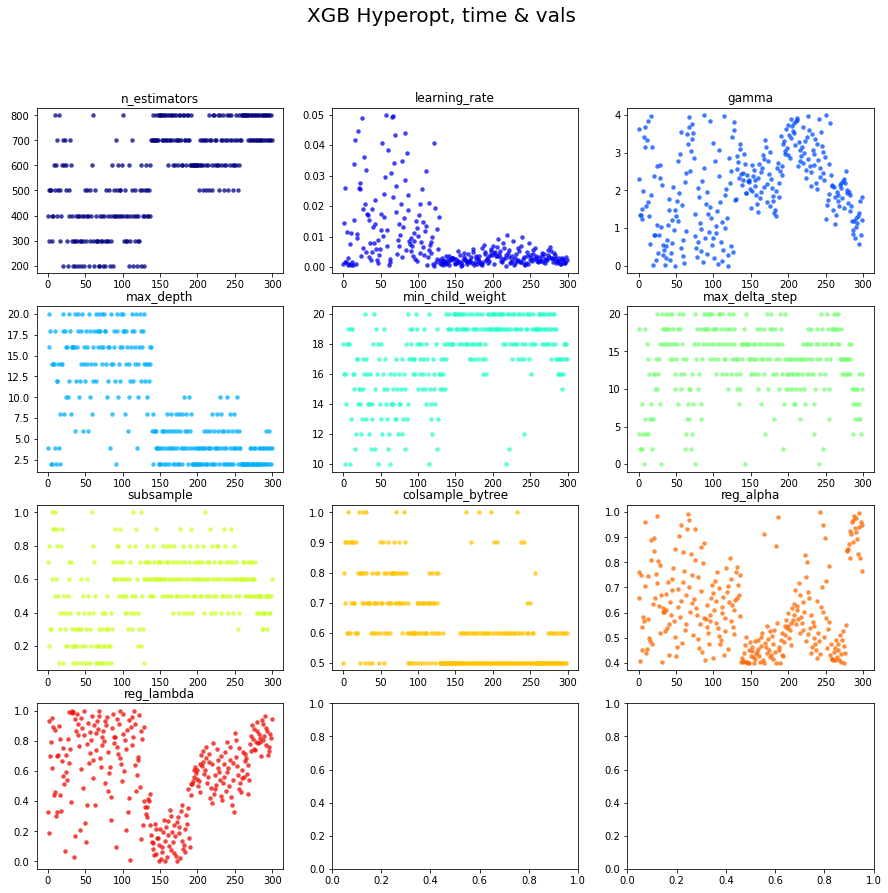

In [17]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, time & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['tid'] for t in trials.trials]).ravel()
    ys = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

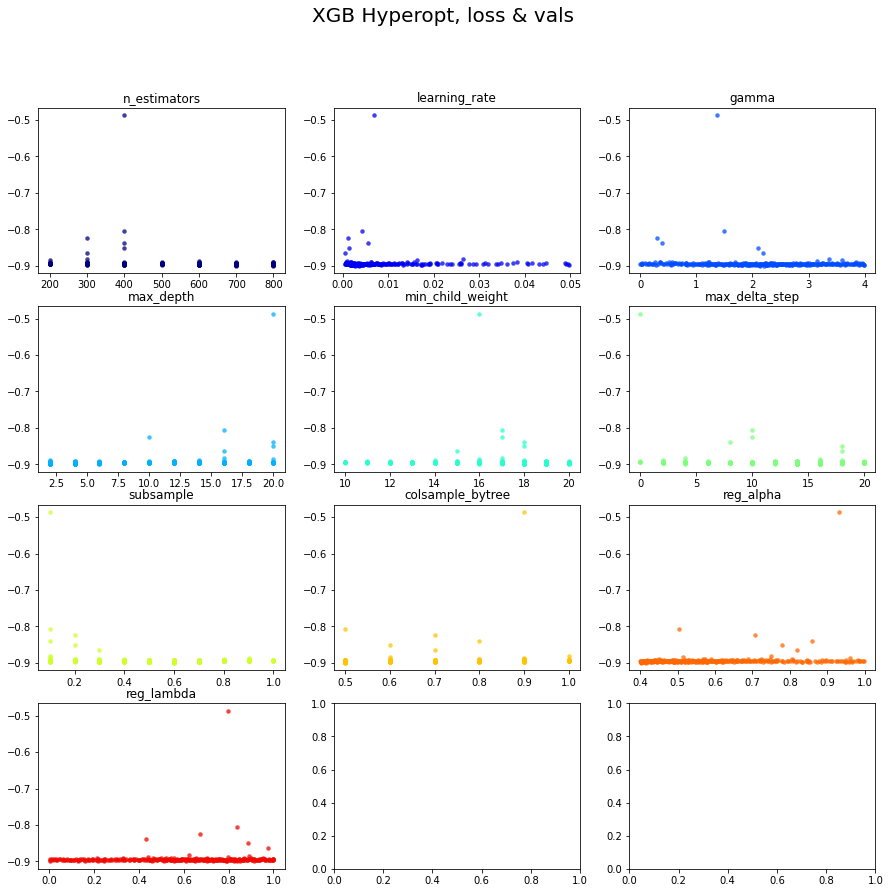

In [18]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, loss & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

### Save Results


In [19]:
# Read basic information of dataset
submission = pd.read_csv(f'{path}/data/public_tag_loc_coor_describe_elevation.csv').sort_values(by=['file']).reset_index(drop=True)
submission['class'] = np.nan
submission.columns

Index(['file', 'height', 'width', 'taken_datetime', 'make', 'model',
       'target_fid', 'target_x', 'target_y', 'county_name', 'town_name',
       'town_x', 'town_y', 'town_z', 'angle', 'class'],
      dtype='object')

In [20]:
# Copy result from each model
for i in range(len(models)):
    result = pd.read_pickle(F'{path}/outputs/public/{models[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    submission[f'predict_{models[i]["name"]}'] = result['predict']
    submission[f'predict_label_{models[i]["name"]}'] = result['predict_label']

In [21]:
# ['XGBoost', 'LightGBM']
model_name = 'XGBoost'

# Build model set
list_of_use_models = [i for i in range(len(models))]

# Print model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

bit-efficientnet-dcnn


In [22]:
# Build x, y for model
x_submission, y_submission = build_x_y(submission, models, list_of_use_models)

# best_params = read_pkl(f'./models/vit-eff6-dcnn(doy-sig)-dcnn(doy)-Hyperopt500(camera).pkl')
# best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0}

# Create the model [LightGBM, XGBoost]
clf = initialize_model(best_params, num_classes)
clf.fit(x_valid, y_valid)
clf.save_model(F"{path}/models/ensemble-xgb-{model_set}-hyperopt{iteration}-2.json")

# load model
# clf.load_model(F"{path}/models/ensemble-xgb-{model_set}.json")

# Predict the response for test dataset
y_pred = clf.predict(x_submission)
y_pred_inverse = labelenc.inverse_transform(y_pred)

# Output result
submission['label'] = list(y_pred_inverse)
# filename
submission[['file', 'label']].rename(columns={'file': 'filename'}).to_csv(F'{path}/submission/public/xgb-{model_set}-hyperopt{iteration}-2.csv', index=False)    